<a href="https://colab.research.google.com/github/Nalucarrera/Modelling-of-a-PEM-Cell-Power-density/blob/main/PEM4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Proton Exchange Membrane (PEM) Fuel Cell

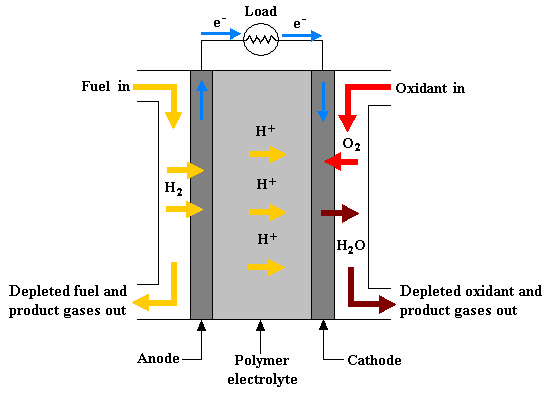

Reação da célula:

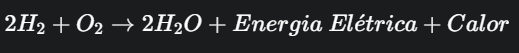

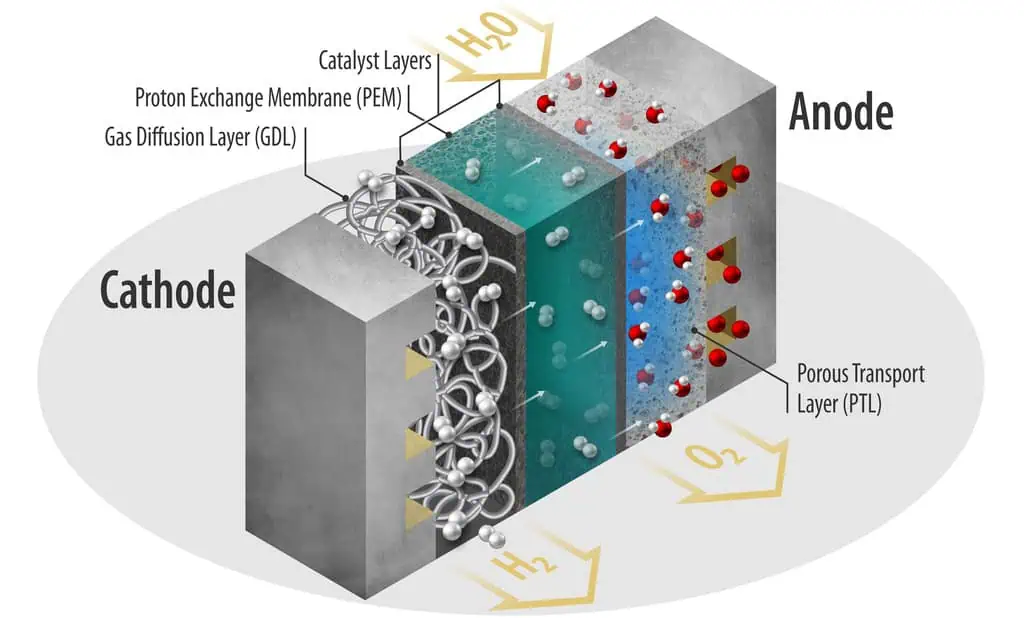

## Montagem do Kernell

Importações e Configurações Iniciais

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # Para o Q-Q plot
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore') # Para ignorar warnings que não interrompem a execução


In [203]:
# Configurações para melhor visualização
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [204]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 Carregamento dos Dados

In [205]:
csv_path = '/content/drive/MyDrive/PEMcell/dados_PEMcell(COMPLETA).csv'
dados = pd.read_csv(csv_path, sep=';')

## Recorte de dados

In [206]:
# Exibir as primeiras linhas e informações para verificar o carregamento
print("Dimensões dos dados:", dados.shape)
print("Primeiras 5 linhas:")
print(dados.head())
print("\nInformações sobre os dados:")
dados.info()
print("\nEstatísticas Descritivas:")
print(dados.describe())

# --- Correção dos nomes das colunas conforme o CSV ---
# Verificar valores únicos em colunas categóricas ou de ID
print("\nValores únicos em 'set':", dados['set'].unique())
print("\nValores únicos em 'type':", dados['type'].unique())

Dimensões dos dados: (43259, 22)
Primeiras 5 linhas:
                                           test_name         type  cathalyst_loading 1  cathalyst_loading 2  set  z_real   z_img  applied_voltage    OCV    MPD      R  R_at_0.5V  i_at_0.8V  i_at_0.5V  i_at_0.3V  current_density  cell_voltage  power_density  pressure  relative_humidity  membrane_compression  nafion_percent
0         Activation Test MEA Constant Current 0.25A  Impedance 1                 0.38                 0.38  1.0   0.121  0.0173              0.3  968.0  215.0  142.0        NaN        NaN        NaN        NaN              NaN           NaN            NaN       NaN                NaN                   NaN             NaN
1  Activation Test MEA Constant Current 0.25A\t\t...  Impedance 1                 0.38                 0.38  1.0   0.125  0.0128              0.3  968.0  215.0  142.0        NaN        NaN        NaN        NaN              NaN           NaN            NaN       NaN                NaN              

Pré-processamento e Limpeza de Dados

In [207]:
# Criar uma cópia para evitar SettingWithCopyWarning
dados_processados = dados.copy()

In [208]:
# Calcular a fração de valores nulos
null_fractions = dados_processados.isnull().sum() / len(dados_processados)
print("\nFração de valores nulos por coluna:")
print(null_fractions[null_fractions > 0].sort_values(ascending=False))


Fração de valores nulos por coluna:
nafion_percent          0.984928
R_at_0.5V               0.971960
i_at_0.8V               0.971960
membrane_compression    0.971960
cell_voltage            0.884302
current_density         0.884302
power_density           0.884302
i_at_0.3V               0.878430
i_at_0.5V               0.877783
set                     0.518505
pressure                0.481495
relative_humidity       0.481495
R                       0.467371
OCV                     0.467371
MPD                     0.439331
z_real                  0.115698
applied_voltage         0.115698
z_img                   0.115698
cathalyst_loading 1     0.028040
cathalyst_loading 2     0.028040
dtype: float64


In [209]:
# Colunas a serem descartadas baseadas na análise inicial do seu notebook
colunas_para_descartar = [
    'test_name', 'z_real', 'z_img', 'applied_voltage',
    'R_at_0.5V', 'i_at_0.8V', 'membrane_compression', 'nafion_percent'
]

dados_processados = dados_processados.drop(columns=colunas_para_descartar, errors='ignore')


In [210]:
# Remover linhas onde 'power_density' é NaN, pois é uma feature central
dados_processados.dropna(subset=['power_density'], inplace=True)

In [211]:
dados_processados.shape
dados_processados.info()
dados_processados.describe()
dados_processados.head()


<class 'pandas.core.frame.DataFrame'>
Index: 5005 entries, 38254 to 43258
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   type                 5005 non-null   object 
 1   cathalyst_loading 1  3792 non-null   float64
 2   cathalyst_loading 2  3792 non-null   float64
 3   set                  1580 non-null   float64
 4   OCV                  3792 non-null   float64
 5   MPD                  5005 non-null   float64
 6   R                    3792 non-null   float64
 7   i_at_0.5V            2768 non-null   float64
 8   i_at_0.3V            2740 non-null   float64
 9   current_density      5005 non-null   float64
 10  cell_voltage         5005 non-null   float64
 11  power_density        5005 non-null   float64
 12  pressure             3425 non-null   float64
 13  relative_humidity    3425 non-null   float64
dtypes: float64(13), object(1)
memory usage: 586.5+ KB


,type,cathalyst_loading 1,cathalyst_loading 2,set,OCV,MPD,R,i_at_0.5V,i_at_0.3V,current_density,cell_voltage,power_density,pressure,relative_humidity
38254,Polarization 1.a,0.38,0.38,NaN,996.0,869.0,64.0,1500.0,2500.0,2550.0,0.296,755.0,5.0,30.0
38255,Polarization 1.a,0.38,0.38,NaN,996.0,869.0,64.0,1500.0,2500.0,2380.0,0.345,821.0,5.0,30.0
38256,Polarization 1.a,0.38,0.38,NaN,996.0,869.0,64.0,1500.0,2500.0,2180.0,0.395,859.0,5.0,30.0
38257,Polarization 1.a,0.38,0.38,NaN,996.0,869.0,64.0,1500.0,2500.0,1950.0,0.446,867.0,5.0,30.0
38258,Polarization 1.a,0.38,0.38,NaN,996.0,869.0,64.0,1500.0,2500.0,1690.0,0.495,839.0,5.0,30.0


In [212]:
dados_processados

,type,cathalyst_loading 1,cathalyst_loading 2,set,OCV,MPD,R,i_at_0.5V,i_at_0.3V,current_density,cell_voltage,power_density,pressure,relative_humidity
38254,Polarization 1.a,0.38,0.38,NaN,996.0,869.0,64.0,1500.0,2500.0,2550.0,0.296,755.0,5.0,30.0
38255,Polarization 1.a,0.38,0.38,NaN,996.0,869.0,64.0,1500.0,2500.0,2380.0,0.345,821.0,5.0,30.0
38256,Polarization 1.a,0.38,0.38,NaN,996.0,869.0,64.0,1500.0,2500.0,2180.0,0.395,859.0,5.0,30.0
38257,Polarization 1.a,0.38,0.38,NaN,996.0,869.0,64.0,1500.0,2500.0,1950.0,0.446,867.0,5.0,30.0
38258,Polarization 1.a,0.38,0.38,NaN,996.0,869.0,64.0,1500.0,2500.0,1690.0,0.495,839.0,5.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43254,"Various Membrane Compression, Various RHC",NaN,NaN,NaN,NaN,625.0,NaN,900.0,1300.0,1160.0,0.383,445.0,25.0,100.0
43255,"Various Membrane Compression, Various RHC",NaN,NaN,NaN,NaN,625.0,NaN,900.0,1300.0,1250.0,0.334,416.0,25.0,100.0
43256,"Various Membrane Compression, Various RHC",NaN,NaN,NaN,NaN,625.0,NaN,900.0,1300.0,1340.0,0.284,379.0,25.0,100.0
43257,"Various Membrane Compression, Various RHC",NaN,NaN,NaN,NaN,625.0,NaN,900.0,1300.0,1420.0,0.234,332.0,25.0,100.0


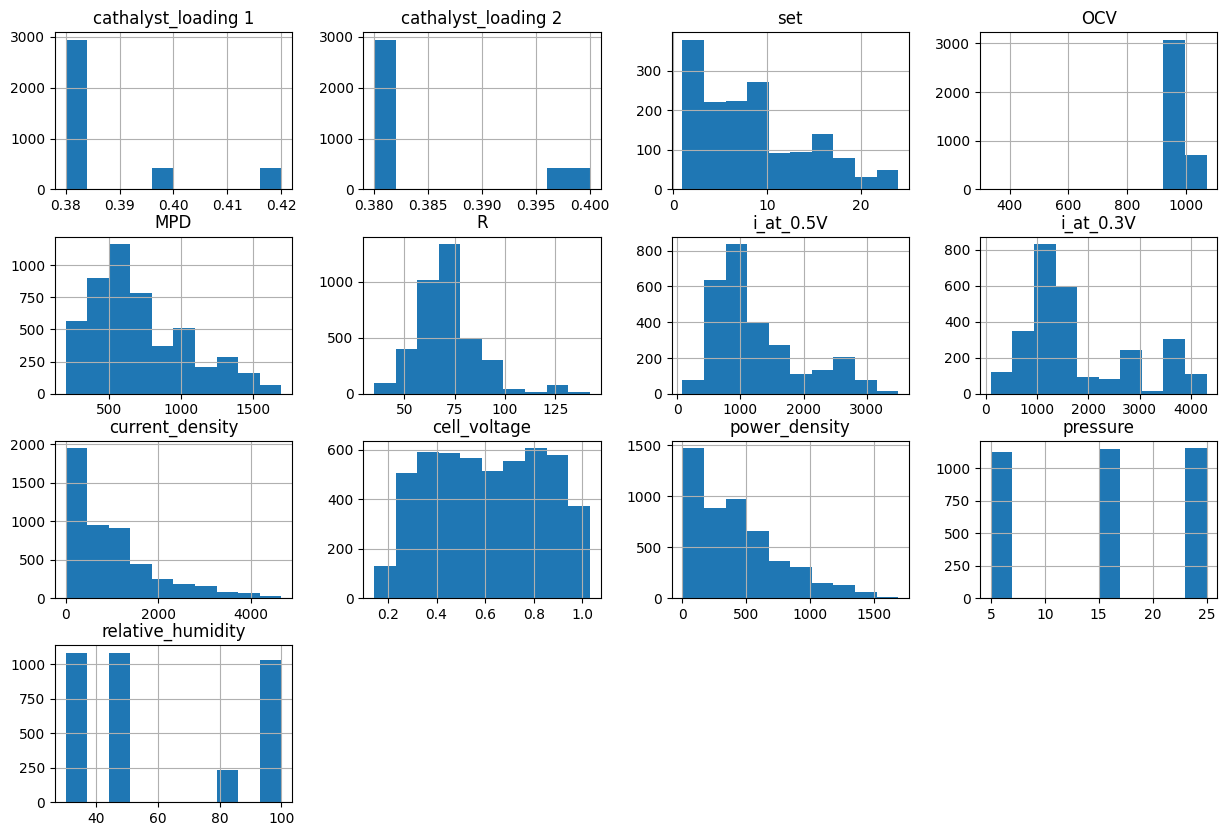

In [213]:
# Visualizar a distribuição dos dados após o pré-processamento (opcional)
dados_processados.hist(figsize=(15, 10))
plt.show()

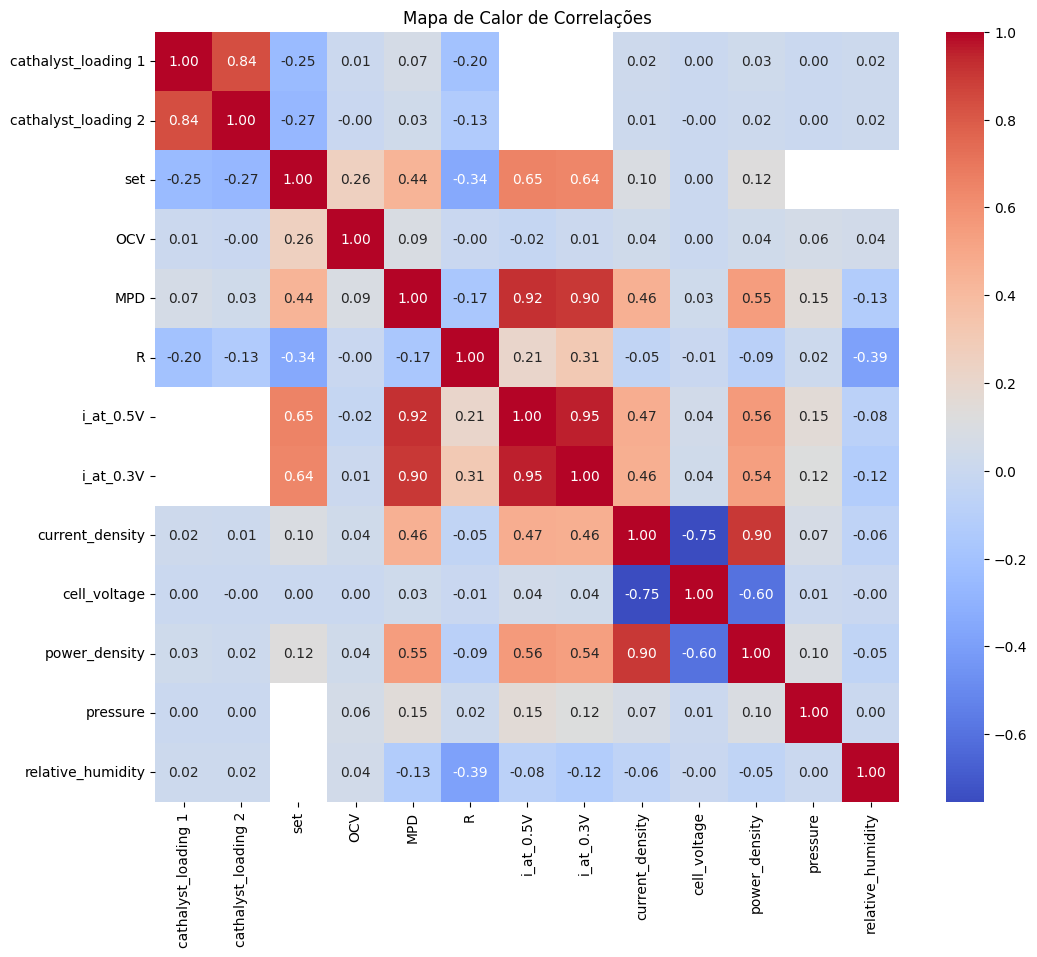

In [214]:
# Visualizar correlações
plt.figure(figsize=(12, 10))

# Select only numerical columns for correlation calculation
numerical_dados_processados = dados_processados.select_dtypes(include=np.number)

sns.heatmap(numerical_dados_processados.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de Correlações')
plt.show()

In [215]:
dados_processados['power_density'].describe()

,power_density
count,5005.000000
mean,421.568894
std,341.575833
min,0.000000
25%,118.000000
50%,365.000000
75%,603.000000
max,1690.000000


In [216]:
dados_processados['current_density'].describe()

,current_density
count,5005.000000
mean,956.037968
std,933.433492
min,0.000000
25%,156.000000
50%,734.000000
75%,1360.000000
max,4650.000000


## Análise Exploratória

In [217]:
# Exibir as primeiras linhas e informações para verificar o carregamento
print("Dimensões dos dados:", dados_processados.shape)
print("Primeiras 5 linhas:")
print(dados_processados.head())
print("\nInformações sobre os dados:")
dados_processados.info()
print("\nEstatísticas Descritivas:")
print(dados_processados.describe())

# Verificar valores únicos em colunas categóricas ou de ID
print("\nValores únicos em 'set':", dados_processados['set'].unique())
print("\nValores únicos em 'type':", dados_processados['type'].unique())

Dimensões dos dados: (5005, 14)
Primeiras 5 linhas:
                   type  cathalyst_loading 1  cathalyst_loading 2  set    OCV    MPD     R  i_at_0.5V  i_at_0.3V  current_density  cell_voltage  power_density  pressure  relative_humidity
38254  Polarization 1.a                 0.38                 0.38  NaN  996.0  869.0  64.0     1500.0     2500.0           2550.0         0.296          755.0       5.0               30.0
38255  Polarization 1.a                 0.38                 0.38  NaN  996.0  869.0  64.0     1500.0     2500.0           2380.0         0.345          821.0       5.0               30.0
38256  Polarization 1.a                 0.38                 0.38  NaN  996.0  869.0  64.0     1500.0     2500.0           2180.0         0.395          859.0       5.0               30.0
38257  Polarization 1.a                 0.38                 0.38  NaN  996.0  869.0  64.0     1500.0     2500.0           1950.0         0.446          867.0       5.0               30.0
38258  P

Análise Bivariada - Correlação

<Axes: >

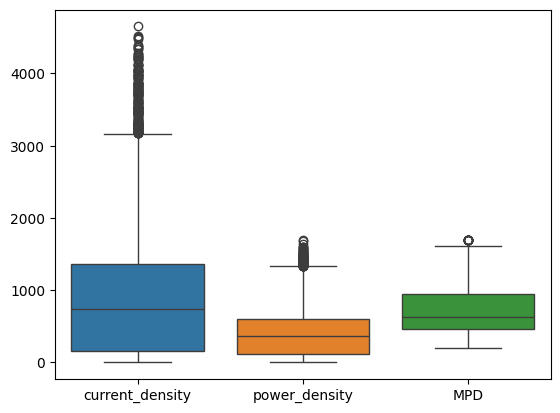

In [218]:
sns.boxplot(data=dados_processados.loc[:,['current_density', 'power_density', 'MPD']])  # Boxplot para visualizar outliers

In [219]:
dadinho = dados_processados.loc[:,['current_density', 'power_density',
                               'cell_voltage']].copy()

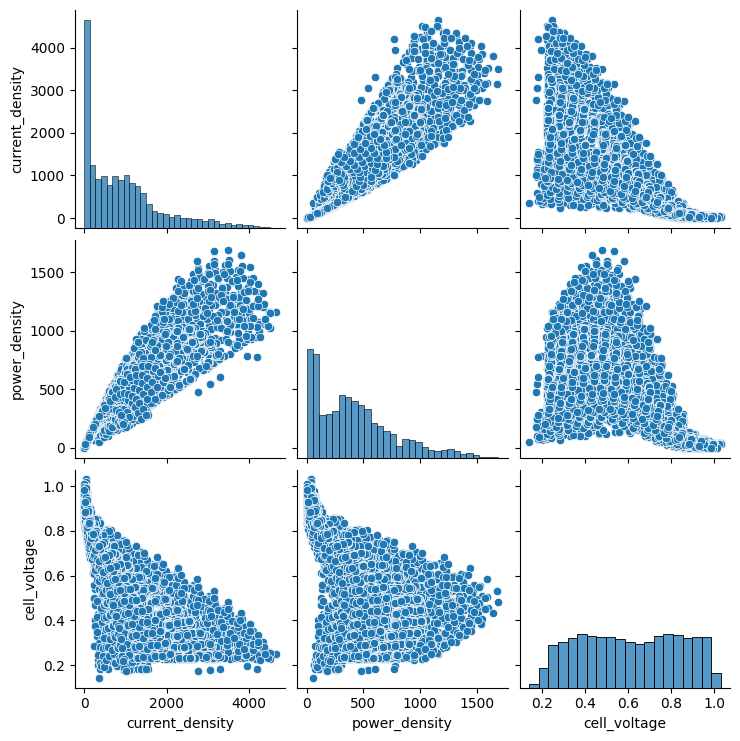

In [220]:
sns.pairplot(dadinho.iloc[:,:])

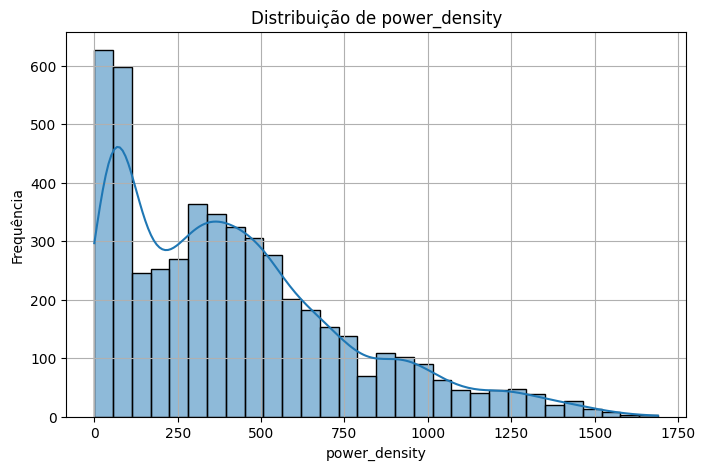

In [221]:
# Histograma da variável de saída
plt.figure(figsize=(8, 5))
sns.histplot(dados_processados['power_density'], kde=True)
plt.title('Distribuição de power_density')
plt.xlabel('power_density')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

## Definição de Variáveis e Divisão dos Dados

Aqui, definimos as features (fatores) e a variável alvo (resposta). A divisão train_test_split será feita mantendo a estratificação pela coluna 'type'.

In [222]:
# Definir a variável de saída (resposta)
resposta = ['power_density']

In [223]:
# Definir as features (fatores) - todas as colunas exceto a resposta
fatores = [col for col in dados_processados.columns if col not in resposta]

In [224]:
X = dados_processados[fatores].copy()
Y = dados_processados[resposta].copy()

In [225]:
# Identificar colunas numéricas e categóricas
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

In [226]:
print(f"\nVariáveis Numéricas: {numerical_features}")
print(f"Variáveis Categóricas: {categorical_features}")


Variáveis Numéricas: ['cathalyst_loading 1', 'cathalyst_loading 2', 'set', 'OCV', 'MPD', 'R', 'i_at_0.5V', 'i_at_0.3V', 'current_density', 'cell_voltage', 'pressure', 'relative_humidity']
Variáveis Categóricas: ['type']


Divisão dos dados em treino e teste, estratificando por 'type'


In [227]:
if 'type' in X.columns:
    X_treino, X_teste, Y_treino, Y_teste = train_test_split(
        X, Y, test_size=0.25, random_state=42, stratify=X['type']
    )
else:
    print("WARNING: Coluna 'type' não encontrada para estratificação. Dividindo sem estratificação.")
    X_treino, X_teste, Y_treino, Y_teste = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )

In [228]:
print(f"\nShape de X_treino: {X_treino.shape}")
print(f"Shape de X_teste: {X_teste.shape}")
print(f"Shape de Y_treino: {Y_treino.shape}")
print(f"Shape de Y_teste: {Y_teste.shape}")


Shape de X_treino: (3753, 13)
Shape de X_teste: (1252, 13)
Shape de Y_treino: (3753, 1)
Shape de Y_teste: (1252, 1)


 Escalonamento da Variável de Saída (Y)

In [229]:
# Inicializar o scaler para a variável Y
scaler_y = MinMaxScaler()

In [230]:
# Ajustar e transformar Y de treino e Y de teste
Y_treino_scaled = scaler_y.fit_transform(Y_treino)
Y_teste_scaled = scaler_y.transform(Y_teste)

print(f"\nVariável de saída Y escalonada. Nova escala de Y_treino: [{Y_treino_scaled.min()}, {Y_treino_scaled.max()}]")


Variável de saída Y escalonada. Nova escala de Y_treino: [0.0, 1.0]


## Criação de Pipelines de Pré-processamento

Esta é uma parte crucial para organizar o fluxo de trabalho. Usaremos ColumnTransformer para aplicar diferentes transformações a diferentes tipos de colunas (numéricas e categóricas) e Pipeline para encadear essas transformações com o modelo.

In [231]:
# Pipeline para features numéricas: imputação com a média e escalonamento Min-Max
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])


In [232]:
# Pipeline para features categóricas: imputação com a moda e One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [233]:
# Combinar os transformadores usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Para obter os nomes das features transformadas (do preprocessor base)
preprocessor.fit(X_treino)
feature_names_transformed = preprocessor.get_feature_names_out()

Outras engenharias de features

In [234]:
X_treino_fe = X_treino.copy()
X_teste_fe = X_teste.copy()

In [235]:
epsilon = 1e-6

In [236]:
#Transformação Logarítmica para Features Skewed (se aplicável, verifique a distribuição das suas features)
# Exemplo: Se 'current_density' ou 'power_density' tiverem caudas longas/skewed
for col in ['current_density', 'power_density']: # Adapte para suas colunas
    if col in X_treino_fe.columns:
        X_treino_fe[f'{col}_log'] = np.log1p(X_treino_fe[col]) # log1p é log(1+x) para lidar com zeros
        X_teste_fe[f'{col}_log'] = np.log1p(X_teste_fe[col])
        print(f"Feature '{col}_log' criada.")
    else:
        print(f"Atenção: '{col}' não encontrada para transformação logarítmica.")


Feature 'current_density_log' criada.
Atenção: 'power_density' não encontrada para transformação logarítmica.


In [237]:
# 1. Termo de Interação entre Pressão e Umidade
if 'pressure' in X_treino_fe.columns and 'relative_humidity' in X_treino_fe.columns:
    X_treino_fe['pressure_humidity_interaction'] = X_treino_fe['pressure'] * X_treino_fe['relative_humidity']
    X_teste_fe['pressure_humidity_interaction'] = X_teste_fe['pressure'] * X_teste_fe['relative_humidity']
    #print("Feature 'pressure_humidity_interaction' criada.")
else:
    print("Atenção: 'pressure' ou 'relative_humidity' não encontradas para 'pressure_humidity_interaction'.")


In [238]:
# 2. Termo Quadrático da Densidade de Corrente
if 'current_density' in X_treino_fe.columns:
    X_treino_fe['current_density_squared'] = X_treino_fe['current_density']**2
    X_teste_fe['current_density_squared'] = X_teste_fe['current_density']**2
    #print("Feature 'current_density_squared' criada.")
else:
    print("Atenção: 'current_density' não encontrada para 'current_density_squared'.")


In [239]:
# 3. Interação entre Densidade de Corrente e Tensão da Célula
if 'current_density' in X_treino_fe.columns and 'cell_voltage' in X_treino_fe.columns:
    X_treino_fe['current_voltage_interaction'] = X_treino_fe['current_density'] * X_treino_fe['cell_voltage']
    X_teste_fe['current_voltage_interaction'] = X_teste_fe['current_density'] * X_teste_fe['cell_voltage']
    #print("Feature 'current_voltage_interaction' criada.")
else:
    print("Atenção: 'current_density' ou 'cell_voltage' não encontradas para 'current_voltage_interaction'.")


In [240]:
# Atualizar a lista de features numéricas para o ColumnTransformer com as novas features
new_numerical_features = X_treino_fe.select_dtypes(include=np.number).columns.tolist()


In [241]:
preprocessor_fe = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, new_numerical_features), # Usa a nova lista de features numéricas
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

In [242]:
# Refit o preprocessor_fe com os dados de treino atualizados para pegar os novos nomes de features
preprocessor_fe.fit(X_treino_fe)
feature_names_transformed_fe = preprocessor_fe.get_feature_names_out()

In [243]:
print("Novas features adicionadas:", list(new_numerical_features))
print(f"Número total de features (treino): {X_treino_fe.shape[1]}")

Novas features adicionadas: ['cathalyst_loading 1', 'cathalyst_loading 2', 'set', 'OCV', 'MPD', 'R', 'i_at_0.5V', 'i_at_0.3V', 'current_density', 'cell_voltage', 'pressure', 'relative_humidity', 'current_density_log', 'pressure_humidity_interaction', 'current_density_squared', 'current_voltage_interaction']
Número total de features (treino): 17


In [244]:
# Dicionário para armazenar os resultados de todos os modelos
model_results = {}
model_results

{}

## Modelagem de Regressão Linear



Agora, vamos montar um pipeline completo para a Regressão Linear, incluindo o pré-processamento.

In [245]:
# Pipeline completo para Regressão Linear
model_linear_regression = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [246]:
# Treinar o modelo
model_linear_regression.fit(X_treino, Y_treino_scaled.ravel())


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['cathalyst_loading 1',
                                                   'cathalyst_loading 2', 'set',
                                                   'OCV', 'MPD', 'R',
                                                   'i_at_0.5V', 'i_at_0.3V',
                                                   'current_density',
                                                   'cell_voltage', 'pressure',
                                                   'relative_humidity']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['type'])])),
                ('regressor', LinearRegression())])

In [247]:
Y_pred_treino_lr_scaled = model_linear_regression.predict(X_treino)
Y_pred_teste_lr_scaled = model_linear_regression.predict(X_teste)
r2_treino_lr_scaled = r2_score(Y_treino_scaled, Y_pred_treino_lr_scaled)
mse_treino_lr_scaled = mean_squared_error(Y_treino_scaled, Y_pred_treino_lr_scaled)
r2_teste_lr_scaled = r2_score(Y_teste_scaled, Y_pred_teste_lr_scaled)
mse_teste_lr_scaled = mean_squared_error(Y_teste_scaled, Y_pred_teste_lr_scaled)
Y_pred_treino_lr_original = scaler_y.inverse_transform(Y_pred_treino_lr_scaled.reshape(-1, 1))
Y_pred_teste_lr_original = scaler_y.inverse_transform(Y_pred_teste_lr_scaled.reshape(-1, 1))
r2_treino_lr_original = r2_score(Y_treino, Y_pred_treino_lr_original)
mse_treino_lr_original = mean_squared_error(Y_treino, Y_pred_treino_lr_original)
r2_teste_lr_original = r2_score(Y_teste, Y_pred_teste_lr_original)
mse_teste_lr_original = mean_squared_error(Y_teste, Y_pred_teste_lr_original)
model_results['Linear Regression'] = {
    'R2 (Treino - Escalonado)': r2_treino_lr_scaled, 'MSE (Treino - Escalonado)': mse_treino_lr_scaled,
    'R2 (Teste - Escalonado)': r2_teste_lr_scaled, 'MSE (Teste - Escalonado)': mse_teste_lr_scaled,
    'R2 (Treino - Original)': r2_treino_lr_original, 'MSE (Treino - Original)': mse_treino_lr_original,
    'R2 (Teste - Original)': r2_teste_lr_original, 'MSE (Teste - Original)': mse_teste_lr_original
}


model_results

{'Linear Regression': {'R2 (Treino - Escalonado)': 0.8300983975483496,
  'MSE (Treino - Escalonado)': 0.007002090964427199,
  'R2 (Teste - Escalonado)': 0.8356501912163805,
  'MSE (Teste - Escalonado)': 0.006850443359336469,
  'R2 (Treino - Original)': 0.8300983975483496,
  'MSE (Treino - Original)': 19762.701537999317,
  'R2 (Teste - Original)': 0.8356501912163805,
  'MSE (Teste - Original)': 19334.69133739125}}

In [248]:
# Para obter os nomes das features após o ColumnTransformer e OneHotEncoder
# Crie um DataFrame temporário para ver os nomes das colunas transformadas
preprocessor.fit(X_treino) # Fit o preprocessor nos dados de treino
feature_names_transformed = preprocessor.get_feature_names_out()

In [249]:
# Obter os coeficientes do modelo de regressão linear
coefficients = model_linear_regression.named_steps['regressor'].coef_[0]

In [250]:
# Criar um DataFrame para exibir os coeficientes
coefficients_df = pd.DataFrame({
    'Feature': feature_names_transformed,
    'Coefficient': coefficients
})
coefficients_df['Absolute_Coefficient'] = np.abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Absolute_Coefficient', ascending=False)

print("\nCoeficientes do Modelo de Regressão Linear (por importância absoluta):")
print(coefficients_df.head(10)) # Exibir os 10 mais importantes


Coeficientes do Modelo de Regressão Linear (por importância absoluta):
                    Feature  Coefficient  Absolute_Coefficient
0  num__cathalyst_loading 1     0.001492              0.001492
1  num__cathalyst_loading 2     0.001492              0.001492
2                  num__set     0.001492              0.001492
3                  num__OCV     0.001492              0.001492
4                  num__MPD     0.001492              0.001492
5                    num__R     0.001492              0.001492
6            num__i_at_0.5V     0.001492              0.001492
7            num__i_at_0.3V     0.001492              0.001492
8      num__current_density     0.001492              0.001492
9         num__cell_voltage     0.001492              0.001492


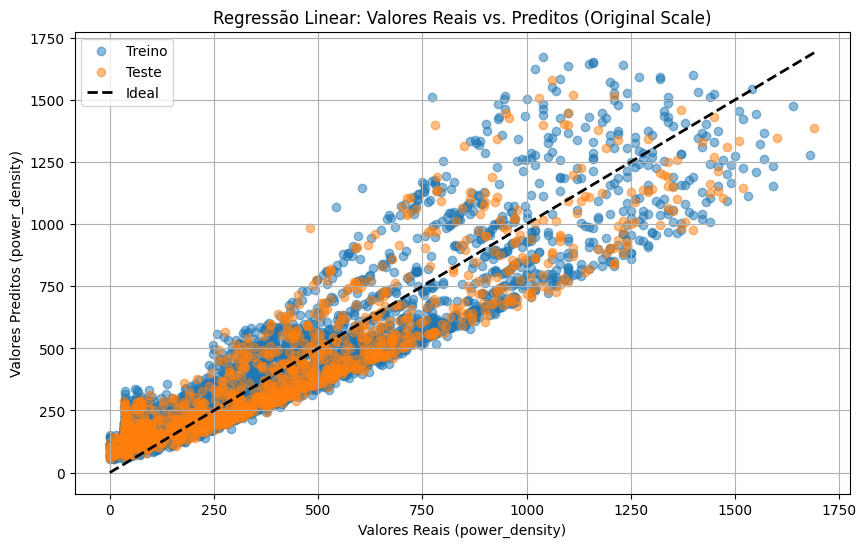


Métricas de Desempenho para Regressão Linear:
R2 (Treino - Escalonado): 0.8301
MSE (Treino - Escalonado): 0.0070
R2 (Teste - Escalonado): 0.8357
MSE (Teste - Escalonado): 0.0069
R2 (Treino - Original): 0.8301
MSE (Treino - Original): 19762.7015
R2 (Teste - Original): 0.8357
MSE (Teste - Original): 19334.6913


In [251]:
# Plotting the Training and Testing Performance for Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(Y_treino, Y_pred_treino_lr_original, alpha=0.5, label='Treino')
plt.scatter(Y_teste, Y_pred_teste_lr_original, alpha=0.5, label='Teste')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('Valores Reais (power_density)')
plt.ylabel('Valores Preditos (power_density)')
plt.title('Regressão Linear: Valores Reais vs. Preditos (Original Scale)')
plt.legend()
plt.grid(True)
plt.show()

print("\nMétricas de Desempenho para Regressão Linear:")
for metric, value in model_results['Linear Regression'].items():
    print(f"{metric}: {value:.4f}")

## Regressão com modelos tipo Árvore de Decisão

In [252]:
# Pipeline completo para RandomForestRegressor
model_random_forest = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_estimators=500))
])
model_random_forest.fit(X_treino, Y_treino_scaled.ravel())

# Avaliar o modelo
Y_pred_treino_rf_scaled = model_random_forest.predict(X_treino)
Y_pred_teste_rf_scaled = model_random_forest.predict(X_teste)
r2_treino_rf_scaled = r2_score(Y_treino_scaled, Y_pred_treino_rf_scaled)
mse_treino_rf_scaled = mean_squared_error(Y_treino_scaled, Y_pred_treino_rf_scaled)
r2_teste_rf_scaled = r2_score(Y_teste_scaled, Y_pred_teste_rf_scaled)
mse_teste_rf_scaled = mean_squared_error(Y_teste_scaled, Y_pred_teste_rf_scaled)
Y_pred_treino_rf_original = scaler_y.inverse_transform(Y_pred_treino_rf_scaled.reshape(-1, 1))
Y_pred_teste_rf_original = scaler_y.inverse_transform(Y_pred_teste_rf_scaled.reshape(-1, 1))
r2_treino_rf_original = r2_score(Y_treino, Y_pred_treino_rf_original)
mse_treino_rf_original = mean_squared_error(Y_treino, Y_pred_treino_rf_original)
r2_teste_rf_original = r2_score(Y_teste, Y_pred_teste_rf_original)
mse_teste_rf_original = mean_squared_error(Y_teste, Y_pred_teste_rf_original)
model_results['RandomForestRegressor'] = {
    'R2 (Treino - Escalonado)': r2_treino_rf_scaled, 'MSE (Treino - Escalonado)': mse_treino_rf_scaled,
    'R2 (Teste - Escalonado)': r2_teste_rf_scaled, 'MSE (Teste - Escalonado)': mse_teste_rf_scaled,
    'R2 (Treino - Original)': r2_treino_rf_original, 'MSE (Treino - Original)': mse_treino_rf_original,
    'R2 (Teste - Original)': r2_teste_rf_original, 'MSE (Teste - Original)': mse_teste_rf_original
}

model_results


{'Linear Regression': {'R2 (Treino - Escalonado)': 0.8300983975483496,
  'MSE (Treino - Escalonado)': 0.007002090964427199,
  'R2 (Teste - Escalonado)': 0.8356501912163805,
  'MSE (Teste - Escalonado)': 0.006850443359336469,
  'R2 (Treino - Original)': 0.8300983975483496,
  'MSE (Treino - Original)': 19762.701537999317,
  'R2 (Teste - Original)': 0.8356501912163805,
  'MSE (Teste - Original)': 19334.69133739125},
 'RandomForestRegressor': {'R2 (Treino - Escalonado)': 0.9996828612935563,
  'MSE (Treino - Escalonado)': 1.3070118461603547e-05,
  'R2 (Teste - Escalonado)': 0.9980125361262961,
  'MSE (Teste - Escalonado)': 8.284164609805364e-05,
  'R2 (Treino - Original)': 0.9996828612935563,
  'MSE (Treino - Original)': 36.88910234602983,
  'R2 (Teste - Original)': 0.9980125361262961,
  'MSE (Teste - Original)': 233.81226194714657}}

In [253]:
# Visualizar a importância das features para RandomForest
# Obter a importância das features do regressor
feature_importances_rf = model_random_forest.named_steps['regressor'].feature_importances_

# Criar um DataFrame para exibir a importância das features
# É crucial que feature_names_transformed esteja disponível. Se não estiver,
# certifique-se de que a célula com 'preprocessor.get_feature_names_out()' foi executada.
feature_importance_df_rf = pd.DataFrame({
    'Feature': feature_names_transformed,
    'Importance': feature_importances_rf
})
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

print("\nImportância das Features no RandomForestRegressor:")
print(feature_importance_df_rf.head(10))


Importância das Features no RandomForestRegressor:
                   Feature  Importance
8     num__current_density    0.716877
4                 num__MPD    0.242147
9        num__cell_voltage    0.036343
6           num__i_at_0.5V    0.001478
7           num__i_at_0.3V    0.001181
5                   num__R    0.000525
3                 num__OCV    0.000522
2                 num__set    0.000191
11  num__relative_humidity    0.000178
10           num__pressure    0.000135


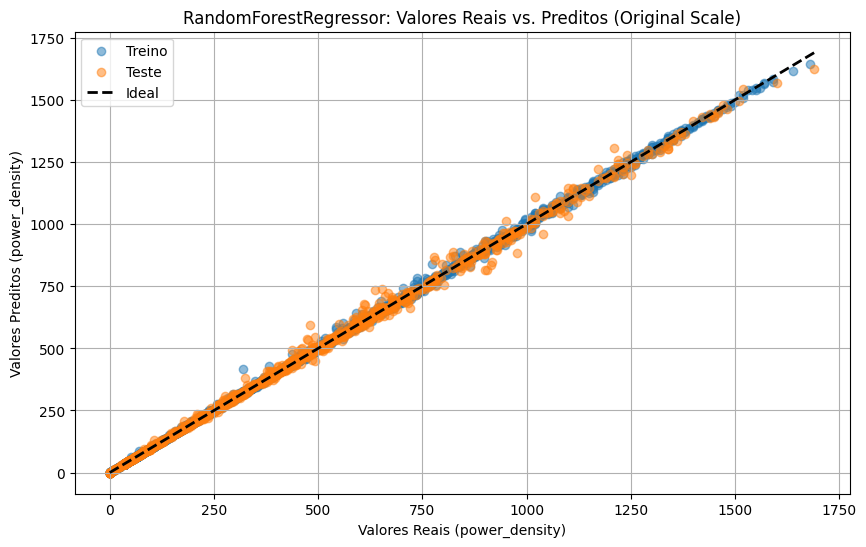


Métricas de Desempenho para RandomForestRegressor:
R2 (Treino - Escalonado): 0.9997
MSE (Treino - Escalonado): 0.0000
R2 (Teste - Escalonado): 0.9980
MSE (Teste - Escalonado): 0.0001
R2 (Treino - Original): 0.9997
MSE (Treino - Original): 36.8891
R2 (Teste - Original): 0.9980
MSE (Teste - Original): 233.8123


In [254]:
# Plotting the Training and Testing Performance for RandomForestRegressor
plt.figure(figsize=(10, 6))
plt.scatter(Y_treino, Y_pred_treino_rf_original, alpha=0.5, label='Treino')
plt.scatter(Y_teste, Y_pred_teste_rf_original, alpha=0.5, label='Teste')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('Valores Reais (power_density)')
plt.ylabel('Valores Preditos (power_density)')
plt.title('RandomForestRegressor: Valores Reais vs. Preditos (Original Scale)')
plt.legend()
plt.grid(True)
plt.show()

print("\nMétricas de Desempenho para RandomForestRegressor:")
for metric, value in model_results['RandomForestRegressor'].items():
    print(f"{metric}: {value:.4f}")


## Regressão por XGBoost

In [255]:
# Pipeline completo para XGBoost
model_xgboost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100))
])

# Treinar o modelo
model_xgboost.fit(X_treino, Y_treino_scaled.ravel())

# Avaliar o modelo
Y_pred_treino_xgb_scaled = model_xgboost.predict(X_treino)
Y_pred_teste_xgb_scaled = model_xgboost.predict(X_teste)
r2_treino_xgb_scaled = r2_score(Y_treino_scaled, Y_pred_treino_xgb_scaled)
mse_treino_xgb_scaled = mean_squared_error(Y_treino_scaled, Y_pred_treino_xgb_scaled)
r2_teste_xgb_scaled = r2_score(Y_teste_scaled, Y_pred_teste_xgb_scaled)
mse_teste_xgb_scaled = mean_squared_error(Y_teste_scaled, Y_pred_teste_xgb_scaled)
Y_pred_treino_xgb_original = scaler_y.inverse_transform(Y_pred_treino_xgb_scaled.reshape(-1, 1))
Y_pred_teste_xgb_original = scaler_y.inverse_transform(Y_pred_teste_xgb_scaled.reshape(-1, 1))
r2_treino_xgb_original = r2_score(Y_treino, Y_pred_treino_xgb_original)
mse_treino_xgb_original = mean_squared_error(Y_treino, Y_pred_treino_xgb_original)
r2_teste_xgb_original = r2_score(Y_teste, Y_pred_teste_xgb_original)
mse_teste_xgb_original = mean_squared_error(Y_teste, Y_pred_teste_xgb_original)
model_results['XGBoost (Base)'] = {
    'R2 (Treino - Escalonado)': r2_treino_xgb_scaled, 'MSE (Treino - Escalonado)': mse_treino_xgb_scaled,
    'R2 (Teste - Escalonado)': r2_teste_xgb_scaled, 'MSE (Teste - Escalonado)': mse_teste_xgb_scaled,
    'R2 (Treino - Original)': r2_treino_xgb_original, 'MSE (Treino - Original)': mse_treino_xgb_original,
    'R2 (Teste - Original)': r2_teste_xgb_original, 'MSE (Teste - Original)': mse_teste_xgb_original
}


model_results


{'Linear Regression': {'R2 (Treino - Escalonado)': 0.8300983975483496,
  'MSE (Treino - Escalonado)': 0.007002090964427199,
  'R2 (Teste - Escalonado)': 0.8356501912163805,
  'MSE (Teste - Escalonado)': 0.006850443359336469,
  'R2 (Treino - Original)': 0.8300983975483496,
  'MSE (Treino - Original)': 19762.701537999317,
  'R2 (Teste - Original)': 0.8356501912163805,
  'MSE (Teste - Original)': 19334.69133739125},
 'RandomForestRegressor': {'R2 (Treino - Escalonado)': 0.9996828612935563,
  'MSE (Treino - Escalonado)': 1.3070118461603547e-05,
  'R2 (Teste - Escalonado)': 0.9980125361262961,
  'MSE (Teste - Escalonado)': 8.284164609805364e-05,
  'R2 (Treino - Original)': 0.9996828612935563,
  'MSE (Treino - Original)': 36.88910234602983,
  'R2 (Teste - Original)': 0.9980125361262961,
  'MSE (Teste - Original)': 233.81226194714657},
 'XGBoost (Base)': {'R2 (Treino - Escalonado)': 0.9998698859606643,
  'MSE (Treino - Escalonado)': 5.362341061127966e-06,
  'R2 (Teste - Escalonado)': 0.998134

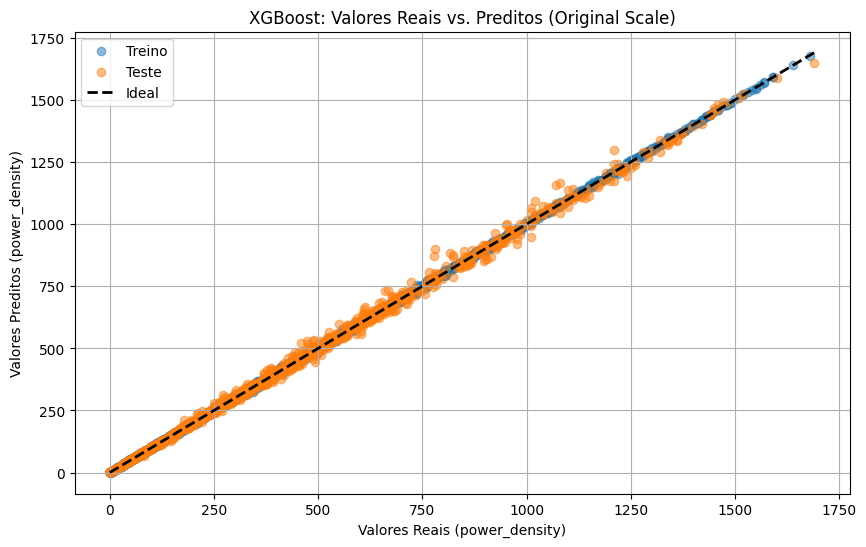


Métricas de Desempenho para XGBoost:
R2 (Treino - Escalonado): 0.9999
MSE (Treino - Escalonado): 0.0000
R2 (Teste - Escalonado): 0.9981
MSE (Teste - Escalonado): 0.0001
R2 (Treino - Original): 0.9999
MSE (Treino - Original): 15.1347
R2 (Teste - Original): 0.9981
MSE (Teste - Original): 219.4726


In [256]:
# Plotting the Training and Testing Performance for XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(Y_treino, Y_pred_treino_xgb_original, alpha=0.5, label='Treino')
plt.scatter(Y_teste, Y_pred_teste_xgb_original, alpha=0.5, label='Teste')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('Valores Reais (power_density)')
plt.ylabel('Valores Preditos (power_density)')
plt.title('XGBoost: Valores Reais vs. Preditos (Original Scale)')
plt.legend()
plt.grid(True)
plt.show()

print("\nMétricas de Desempenho para XGBoost:")
for metric, value in model_results['XGBoost (Base)'].items():
    print(f"{metric}: {value:.4f}")

## Modelo de NN para Regressão

In [281]:
# Transformar os dados de X usando o preprocessor base antes de passar para a NN
X_treino_processed_base = preprocessor_fe.fit_transform(X_treino_fe)
X_teste_processed_base = preprocessor_fe.transform(X_teste_fe)

# Definir a arquitetura da Rede Neural
model_keras = Sequential([
    Dense(64, activation='relu', input_shape=(X_treino_processed_base.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

# Compilar o modelo
model_keras.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [282]:
# Treinar o modelo
history = model_keras.fit(X_treino_processed_base, Y_treino_scaled,
                          epochs=500, batch_size=32, validation_split=0.2, verbose=0)
history


In [283]:
# Avaliar o modelo
Y_pred_treino_keras_scaled = model_keras.predict(X_treino_processed_base)
Y_pred_teste_keras_scaled = model_keras.predict(X_teste_processed_base)
r2_treino_keras_scaled = r2_score(Y_treino_scaled, Y_pred_treino_keras_scaled)
mse_treino_keras_scaled = mean_squared_error(Y_treino_scaled, Y_pred_treino_keras_scaled)
r2_teste_keras_scaled = r2_score(Y_teste_scaled, Y_pred_teste_keras_scaled)
mse_teste_keras_scaled = mean_squared_error(Y_teste_scaled, Y_pred_teste_keras_scaled)
Y_pred_treino_keras_original = scaler_y.inverse_transform(Y_pred_treino_keras_scaled.reshape(-1,1))
Y_pred_teste_keras_original = scaler_y.inverse_transform(Y_pred_teste_keras_scaled.reshape(-1,1))
r2_treino_keras_original = r2_score(Y_treino, Y_pred_treino_keras_original)
mse_treino_keras_original = mean_squared_error(Y_treino, Y_pred_treino_keras_original)
r2_teste_keras_original = r2_score(Y_teste, Y_pred_teste_keras_original)
mse_teste_keras_original = mean_squared_error(Y_teste, Y_pred_teste_keras_original)
model_results['Keras Neural Network'] = {
    'R2 (Treino - Escalonado)': r2_treino_keras_scaled, 'MSE (Treino - Escalonado)': mse_treino_keras_scaled,
    'R2 (Teste - Escalonado)': r2_teste_keras_scaled, 'MSE (Teste - Escalonado)': mse_teste_keras_scaled,
    'R2 (Treino - Original)': r2_treino_keras_original, 'MSE (Treino - Original)': mse_treino_keras_original,
    'R2 (Teste - Original)': r2_teste_keras_original, 'MSE (Teste - Original)': mse_teste_keras_original
}

model_results

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


{'Linear Regression': {'R2 (Treino - Escalonado)': 0.8300983975483496,
  'MSE (Treino - Escalonado)': 0.007002090964427199,
  'R2 (Teste - Escalonado)': 0.8356501912163805,
  'MSE (Teste - Escalonado)': 0.006850443359336469,
  'R2 (Treino - Original)': 0.8300983975483496,
  'MSE (Treino - Original)': 19762.701537999317,
  'R2 (Teste - Original)': 0.8356501912163805,
  'MSE (Teste - Original)': 19334.69133739125},
 'RandomForestRegressor': {'R2 (Treino - Escalonado)': 0.9996828612935563,
  'MSE (Treino - Escalonado)': 1.3070118461603547e-05,
  'R2 (Teste - Escalonado)': 0.9980125361262961,
  'MSE (Teste - Escalonado)': 8.284164609805364e-05,
  'R2 (Treino - Original)': 0.9996828612935563,
  'MSE (Treino - Original)': 36.88910234602983,
  'R2 (Teste - Original)': 0.9980125361262961,
  'MSE (Teste - Original)': 233.81226194714657},
 'XGBoost (Base)': {'R2 (Treino - Escalonado)': 0.9998698859606643,
  'MSE (Treino - Escalonado)': 5.362341061127966e-06,
  'R2 (Teste - Escalonado)': 0.998134

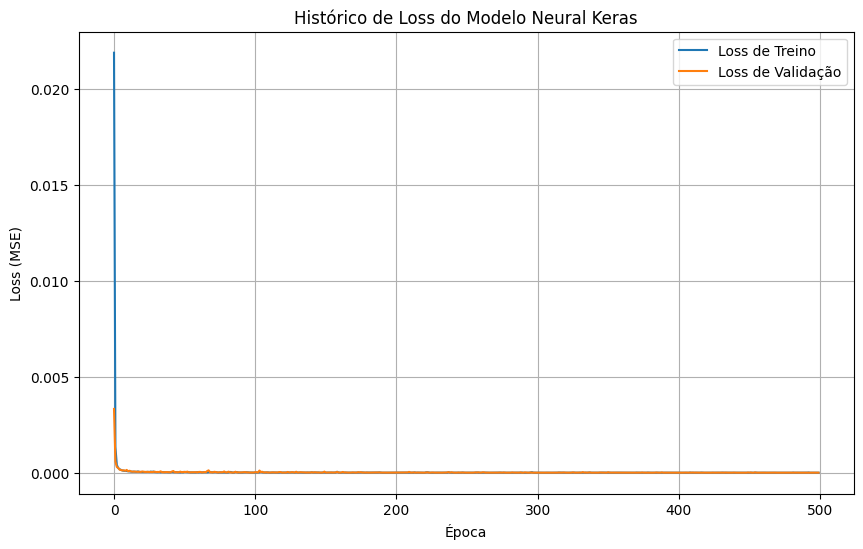

In [284]:
# Plotar histórico de loss (já está usando o loss do treinamento que é baseado em Y_treino_scaled)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Loss de Treino')
plt.plot(history.history['val_loss'], label='Loss de Validação')
plt.title('Histórico de Loss do Modelo Neural Keras')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()



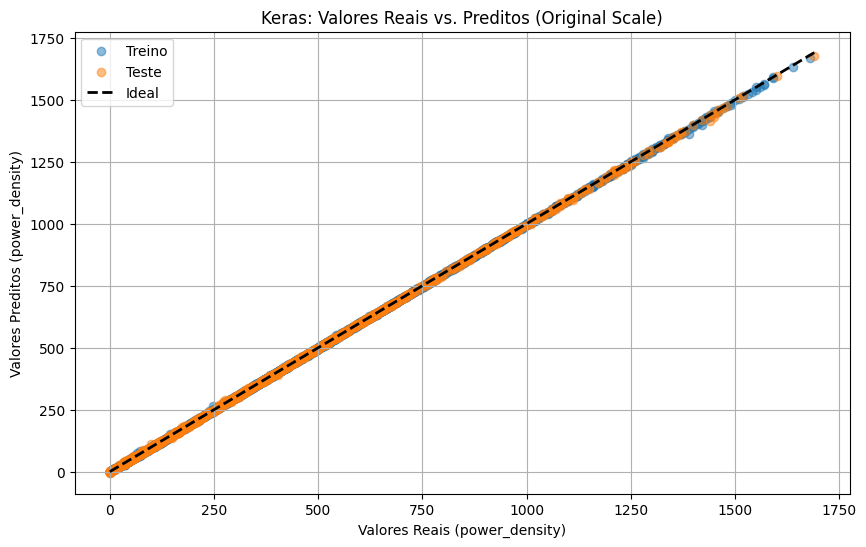


Métricas de Desempenho para Keras:
R2 (Treino - Escalonado): 0.9999
MSE (Treino - Escalonado): 0.0000
R2 (Teste - Escalonado): 0.9999
MSE (Teste - Escalonado): 0.0000
R2 (Treino - Original): 0.9999
MSE (Treino - Original): 9.5904
R2 (Teste - Original): 0.9999
MSE (Teste - Original): 12.5252


In [286]:
# prompt: mostre os gráficos de treino e teste para model_Keras

import matplotlib.pyplot as plt
# Plotting the Training and Testing Performance for Keras
plt.figure(figsize=(10, 6))
plt.scatter(Y_treino, Y_pred_treino_keras_original, alpha=0.5, label='Treino')
plt.scatter(Y_teste, Y_pred_teste_keras_original, alpha=0.5, label='Teste')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('Valores Reais (power_density)')
plt.ylabel('Valores Preditos (power_density)')
plt.title('Keras: Valores Reais vs. Preditos (Original Scale)')
plt.legend()
plt.grid(True)
plt.show()

print("\nMétricas de Desempenho para Keras:")
for metric, value in model_results['Keras Neural Network'].items():
    print(f"{metric}: {value:.4f}")

## Cross-Validation e a Otimização de Hiperparâmetros

In [262]:
# 1. Definir o Pipeline completo para o XGBoost, incluindo o pré-processador
pipeline_xgb_fe = Pipeline(steps=[
    ('preprocessor', preprocessor_fe), # Usa o preprocessor_fe (com novas features)
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

In [263]:
# 2. Definir o Grid de Hiperparâmetros para otimização
# Param_grid expandido - Você pode ajustar esses valores
param_grid_xgb = {
    'regressor__n_estimators': [100, 200, 300, 400], # Mais árvores
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.15], # Mais opções de learning rate
    'regressor__max_depth': [3, 5, 7, 9], # Mais opções de profundidade
    'regressor__subsample': [0.7, 0.8, 0.9, 1.0],
    'regressor__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'regressor__gamma': [0, 0.1, 0.2] # Adicionando gamma
}

In [264]:
# 3. Configurar o GridSearchCV
# cv=5 significa 5-fold cross-validation
# scoring='neg_mean_squared_error' para otimizar o MSE (o GridSearchCV tenta maximizar, então negamos)
# n_jobs=-1 usa todos os núcleos da CPU para paralelizar a busca
grid_search_xgb_fe = GridSearchCV(
    estimator=pipeline_xgb_fe,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=0,
    return_train_score=True
)


In [265]:
# 4. Executar a Busca no Grid de Hiperparâmetros
grid_search_xgb_fe.fit(X_treino_fe, Y_treino_scaled.ravel()) # Usa X_treino_fe

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['cathalyst_loading '
                                                                          '1',
                                                                          'cathalyst_loading '
                                                                          '2',
                                                                          'set',
                                                                          'OCV',
                                                                          'MPD',
                                                                          'R',
                                                                          'i_at_0.5V',
                                                                          'i_at_0.3V',
                                                                          'current_density',
                                                                          'cell_voltage',
                                                                          'pressure',
                                                                          'relative_humidity...
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'regressor__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
                         'regressor__gamma': [0, 0.1, 0.2],
                         'regressor__learning_rate': [0.01, 0.05, 0.1, 0.15],
                         'regressor__max_depth': [3, 5, 7, 9],
                         'regressor__n_estimators': [100, 200, 300, 400],
                         'regressor__subsample': [0.7, 0.8, 0.9, 1.0]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [266]:
# 5. Imprimir os melhores parâmetros e a melhor pontuação
print("\n--- Melhores Hiperparâmetros para XGBoost (Validação Cruzada) com Novas Features ---")
print(f"Melhor pontuação (neg_mean_squared_error): {grid_search_xgb_fe.best_score_:.4f}")
print(f"Melhores parâmetros: {grid_search_xgb_fe.best_params_}")


--- Melhores Hiperparâmetros para XGBoost (Validação Cruzada) com Novas Features ---
Melhor pontuação (neg_mean_squared_error): -0.0000
Melhores parâmetros: {'regressor__colsample_bytree': 1.0, 'regressor__gamma': 0, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 300, 'regressor__subsample': 0.9}


In [267]:
# O melhor modelo encontrado pelo GridSearchCV
best_xgb_model_fe = grid_search_xgb_fe.best_estimator_

In [268]:
# Avaliar o melhor modelo no conjunto de teste com novas features
Y_pred_treino_best_xgb_fe_scaled = best_xgb_model_fe.predict(X_treino_fe)
Y_pred_teste_best_xgb_fe_scaled = best_xgb_model_fe.predict(X_teste_fe)

r2_treino_best_xgb_fe_scaled = r2_score(Y_treino_scaled, Y_pred_treino_best_xgb_fe_scaled)
mse_treino_best_xgb_fe_scaled = mean_squared_error(Y_treino_scaled, Y_pred_treino_best_xgb_fe_scaled)
r2_teste_best_xgb_fe_scaled = r2_score(Y_teste_scaled, Y_pred_teste_best_xgb_fe_scaled)
mse_teste_best_xgb_fe_scaled = mean_squared_error(Y_teste_scaled, Y_pred_teste_best_xgb_fe_scaled)

Y_pred_treino_best_xgb_fe_original = scaler_y.inverse_transform(Y_pred_treino_best_xgb_fe_scaled.reshape(-1, 1))
Y_pred_teste_best_xgb_fe_original = scaler_y.inverse_transform(Y_pred_teste_best_xgb_fe_scaled.reshape(-1, 1))

r2_treino_best_xgb_fe_original = r2_score(Y_treino, Y_pred_treino_best_xgb_fe_original)
mse_treino_best_xgb_fe_original = mean_squared_error(Y_treino, Y_pred_treino_best_xgb_fe_original)
r2_teste_best_xgb_fe_original = r2_score(Y_teste, Y_pred_teste_best_xgb_fe_original)
mse_teste_best_xgb_fe_original = mean_squared_error(Y_teste, Y_pred_teste_best_xgb_fe_original)

model_results['XGBoost (Otimizado + FE)'] = {
    'R2 (Treino - Escalonado)': r2_treino_best_xgb_fe_scaled,
    'MSE (Treino - Escalonado)': mse_treino_best_xgb_fe_scaled,
    'R2 (Teste - Escalonado)': r2_teste_best_xgb_fe_scaled,
    'MSE (Teste - Escalonado)': mse_teste_best_xgb_fe_scaled,
    'R2 (Treino - Original)': r2_treino_best_xgb_fe_original,
    'MSE (Treino - Original)': mse_treino_best_xgb_fe_original,
    'R2 (Teste - Original)': r2_teste_best_xgb_fe_original,
    'MSE (Teste - Original)': mse_teste_best_xgb_fe_original
}

tabela de comparação atualizada:

In [269]:
comparison_df = pd.DataFrame(model_results).T
print(comparison_df.to_string(float_format="%.10f"))

                          R2 (Treino - Escalonado)  MSE (Treino - Escalonado)  R2 (Teste - Escalonado)  MSE (Teste - Escalonado)  R2 (Treino - Original)  MSE (Treino - Original)  R2 (Teste - Original)  MSE (Teste - Original)
Linear Regression                     0.8300983975               0.0070020910             0.8356501912              0.0068504434            0.8300983975         19762.7015379993           0.8356501912        19334.6913373913
RandomForestRegressor                 0.9996828613               0.0000130701             0.9980125361              0.0000828416            0.9996828613            36.8891023460           0.9980125361          233.8122619471
XGBoost (Base)                        0.9998698860               0.0000053623             0.9981344264              0.0000777610            0.9998698831            15.1346712112           0.9981344342          219.4726409912
Keras Neural Network                  0.9997177698               0.0000116314             0.99970638

## Curvas de Polarização

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


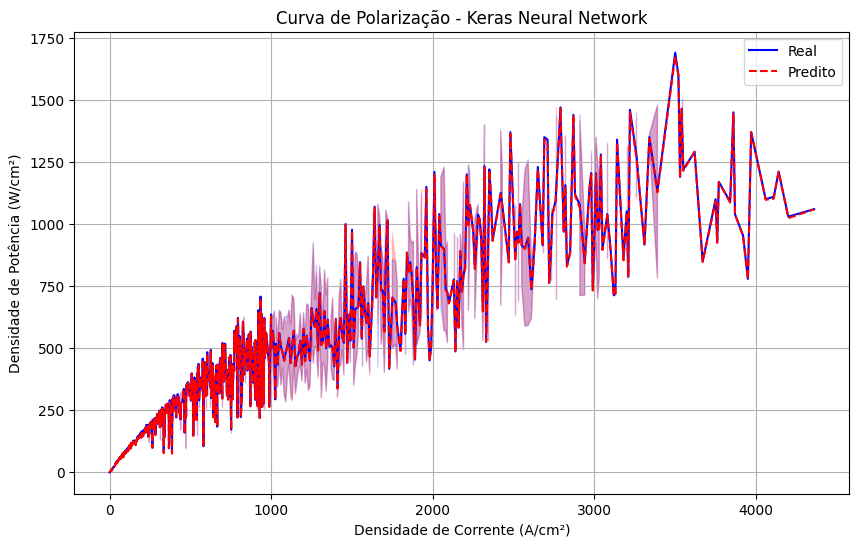

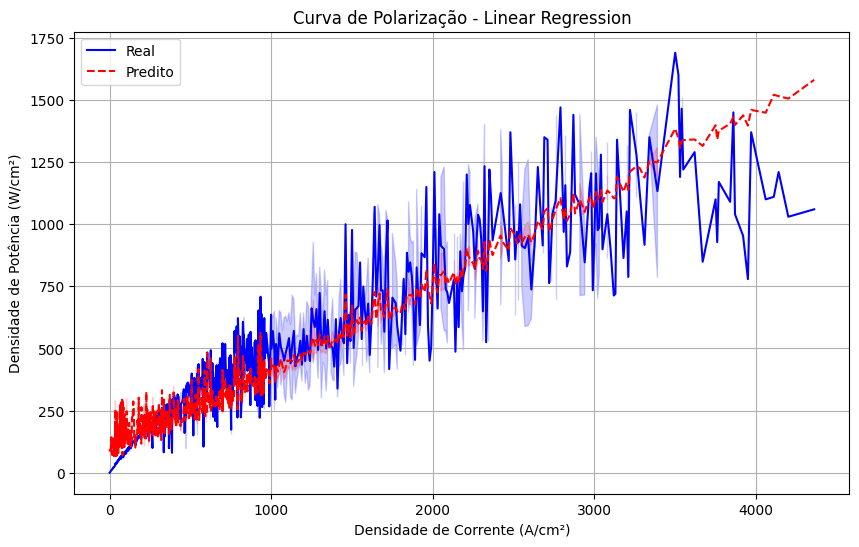

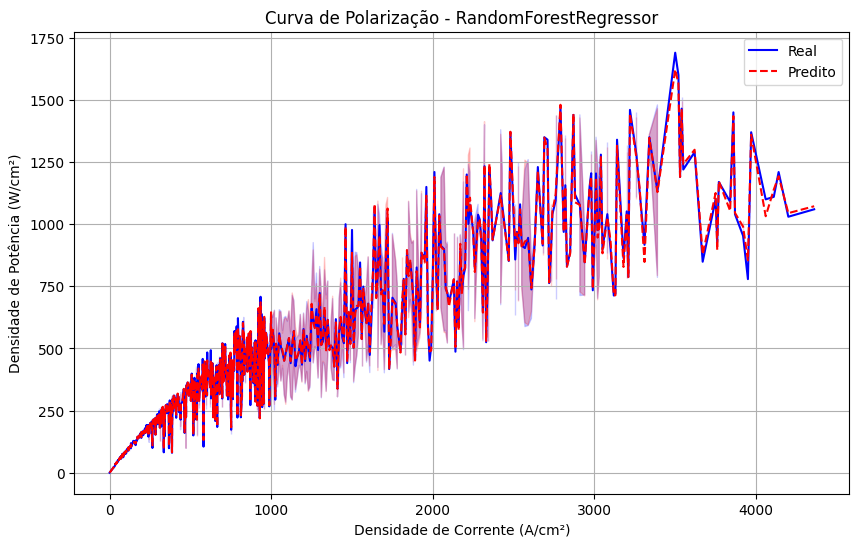

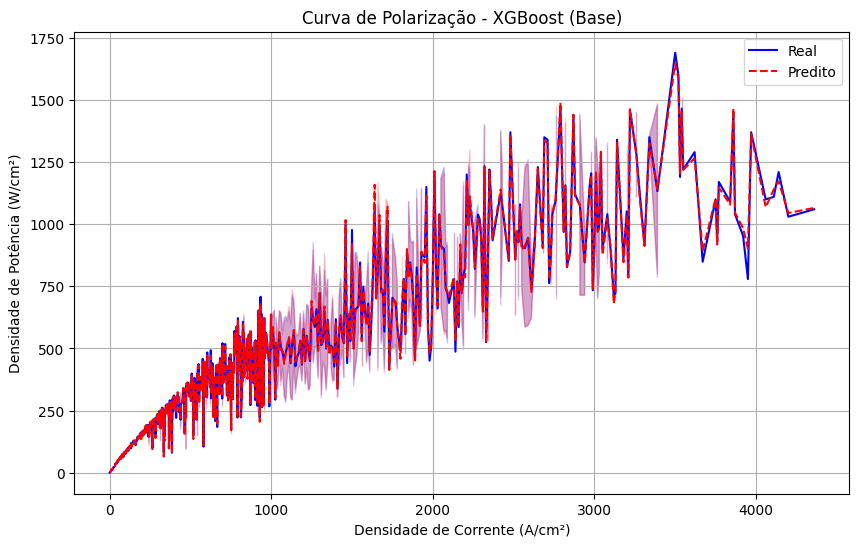

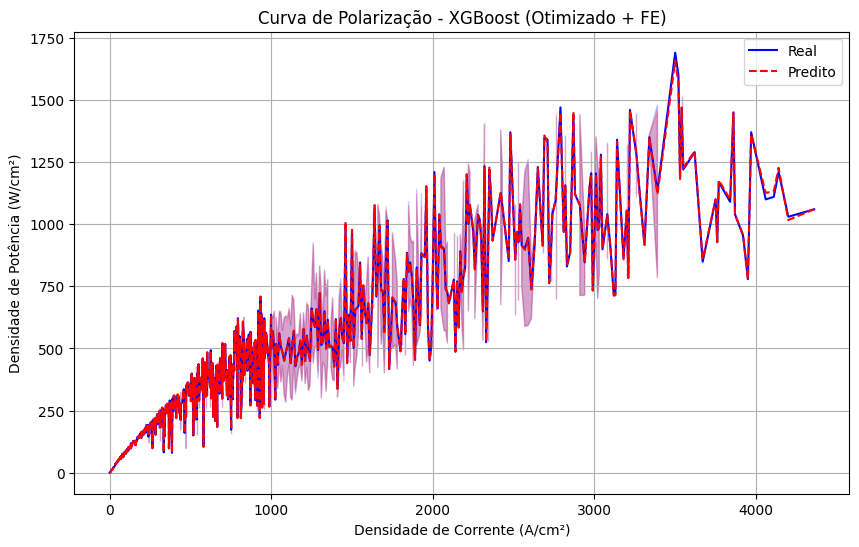

In [287]:

def plot_polarization_curve(model, X_data, Y_real, scaler_y, title):
    """
    Gera um gráfico de curva de polarização (Densidade de Potência vs. Densidade de Corrente)
    usando as previsões de um modelo.

    Args:
        model: O modelo treinado (Pipeline, Keras model, etc.).
        X_data (pd.DataFrame): Os dados de entrada (features).
        Y_real (pd.DataFrame or np.ndarray): Os valores reais da variável de saída.
        scaler_y: O scaler usado para escalar a variável de saída.
        title (str): O título do gráfico.
    """
    # Garantir que X_data seja uma cópia para evitar modificar o original
    X_data_copy = X_data.copy()

    # Assegurar que 'current_density' esteja presente nos dados
    if 'current_density' not in X_data_copy.columns:
        print(f"Erro: A coluna 'current_density' não foi encontrada nos dados para {title}.")
        return

    # Fazer previsões com o modelo
    # Se o modelo é um pipeline, ele lida com o pré-processamento internamente
    # Se o modelo é Keras, os dados de X já devem ter sido pré-processados
    if isinstance(model, Pipeline):
        Y_pred_scaled = model.predict(X_data_copy)
    elif isinstance(model, Sequential): # Para modelos Keras
        # Assumimos que X_data_copy já está pré-processado para o modelo Keras
        # Mas para segurança, se estivesse usando o ColumnTransformer diretamente aqui,
        # precisaria aplicar o preprocessor_fe primeiro.
        # No contexto do código fornecido, o modelo Keras foi treinado com
        # X_treino_processed_base/X_teste_processed_base.
        # Precisamos garantir que X_data para a predição esteja no mesmo formato.
        # Como o modelo Keras não está em um Pipeline que inclui o preprocessor_fe,
        # precisamos pré-processar X_data_copy antes de prever.
        X_data_processed = preprocessor_fe.transform(X_data_copy)
        Y_pred_scaled = model.predict(X_data_processed)
    else:
        print(f"Tipo de modelo desconhecido: {type(model)}")
        return


    # Inverter a escala da variável de saída predita
    Y_pred_original = scaler_y.inverse_transform(Y_pred_scaled.reshape(-1, 1))

    # Criar um DataFrame temporário para plotagem, combinando dados de corrente,
    # potência real e potência predita
    plot_data = pd.DataFrame({
        'current_density': X_data_copy['current_density'],
        'power_density_real': Y_real.values.ravel(), # Usar .values.ravel() para garantir array 1D
        'power_density_pred': Y_pred_original.ravel() # Usar .ravel() para garantir array 1D
    })

    # Ordenar os dados pela densidade de corrente para uma linha suave
    plot_data = plot_data.sort_values(by='current_density')

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=plot_data, x='current_density', y='power_density_real', label='Real', color='blue')
    sns.lineplot(data=plot_data, x='current_density', y='power_density_pred', label='Predito', color='red', linestyle='--')

    plt.title(f'Curva de Polarização - {title}')
    plt.xlabel('Densidade de Corrente (A/cm²)') # Ajuste a unidade se necessário
    plt.ylabel('Densidade de Potência (W/cm²)') # Ajuste a unidade se necessário
    plt.legend()
    plt.grid(True)
    plt.show()

# Agora chame a função para cada modelo treinado, usando os dados de teste
# para visualizar a performance em dados não vistos durante o treino

# Gráfico para o modelo Keras Neural Network
plot_polarization_curve(model_keras, X_teste_fe, Y_teste, scaler_y, 'Keras Neural Network')

# Gráfico para o modelo Linear Regression
plot_polarization_curve(model_linear_regression, X_teste, Y_teste, scaler_y, 'Linear Regression')

# Gráfico para o modelo RandomForestRegressor
plot_polarization_curve(model_random_forest, X_teste, Y_teste, scaler_y, 'RandomForestRegressor')

# Gráfico para o modelo XGBoost Base
plot_polarization_curve(model_xgboost, X_teste, Y_teste, scaler_y, 'XGBoost (Base)')

# Gráfico para o modelo XGBoost Otimizado com Feature Engineering
plot_polarization_curve(best_xgb_model_fe, X_teste_fe, Y_teste, scaler_y, 'XGBoost (Otimizado + FE)')


## Análise de Erros

In [270]:
Y_teste_np = Y_teste.values.ravel() if isinstance(Y_teste, pd.DataFrame) else Y_teste.ravel()
Y_pred_teste_best_xgb_fe_original_np = Y_pred_teste_best_xgb_fe_original.ravel()
residuos = Y_teste_np - Y_pred_teste_best_xgb_fe_original_np

In [271]:
print(f"\nMédia dos Resíduos: {np.mean(residuos):.4f}")
print(f"Desvio Padrão dos Resíduos: {np.std(residuos):.4f}")
print(f"Min Resíduos: {np.min(residuos):.4f}")
print(f"Max Resíduos: {np.max(residuos):.4f}")


Média dos Resíduos: 0.3288
Desvio Padrão dos Resíduos: 3.6154
Min Resíduos: -27.1975
Max Resíduos: 33.1169


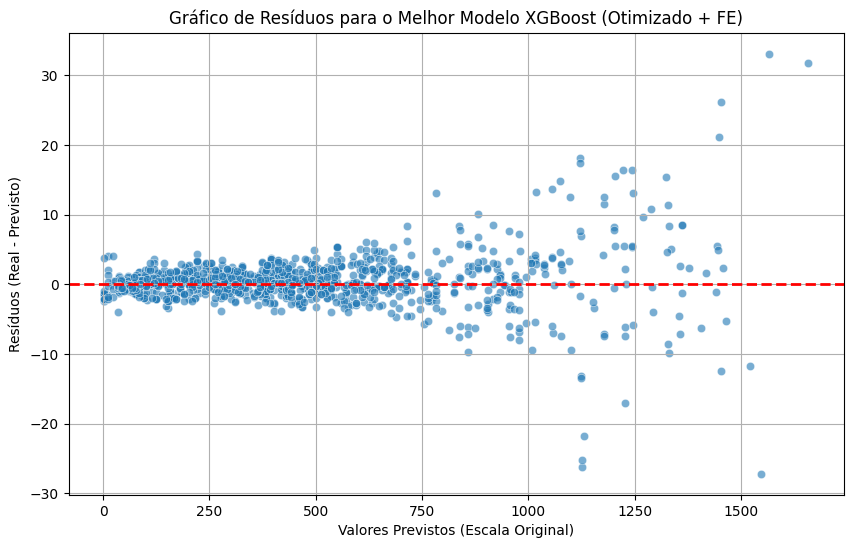

In [272]:
# Gráfico de Resíduos (Resíduos vs. Valores Previstos)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=Y_pred_teste_best_xgb_fe_original_np, y=residuos, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Valores Previstos (Escala Original)')
plt.ylabel('Resíduos (Real - Previsto)')
plt.title('Gráfico de Resíduos para o Melhor Modelo XGBoost (Otimizado + FE)')
plt.grid(True)
plt.savefig('xgb_fe_residual_plot.png')
plt.show()

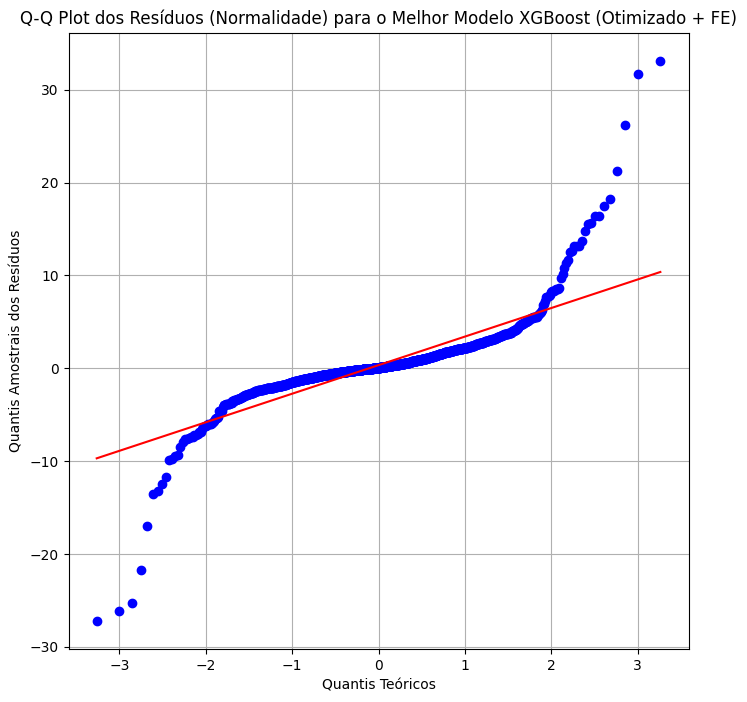

In [273]:
# Q-Q Plot dos Resíduos
plt.figure(figsize=(8, 8))
stats.probplot(residuos, dist="norm", plot=plt)
plt.title('Q-Q Plot dos Resíduos (Normalidade) para o Melhor Modelo XGBoost (Otimizado + FE)')
plt.xlabel('Quantis Teóricos')
plt.ylabel('Quantis Amostrais dos Resíduos')
plt.grid(True)
plt.savefig('xgb_fe_residuals_qq_plot.png')
plt.show()



--- Análise dos Resíduos do Modelo Keras ---
Média dos Resíduos Keras: 2.2345
Desvio Padrão dos Resíduos Keras: 2.7445
Min Resíduos Keras: -13.7604
Max Resíduos Keras: 23.9575


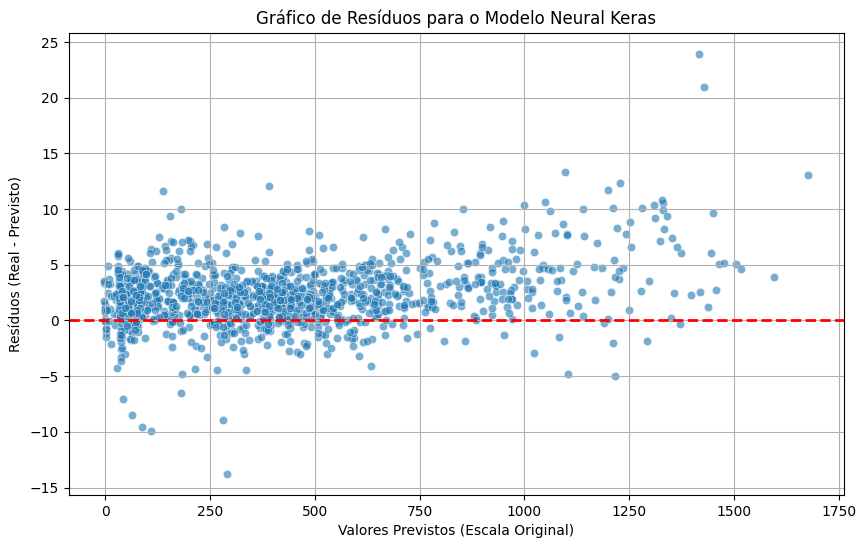

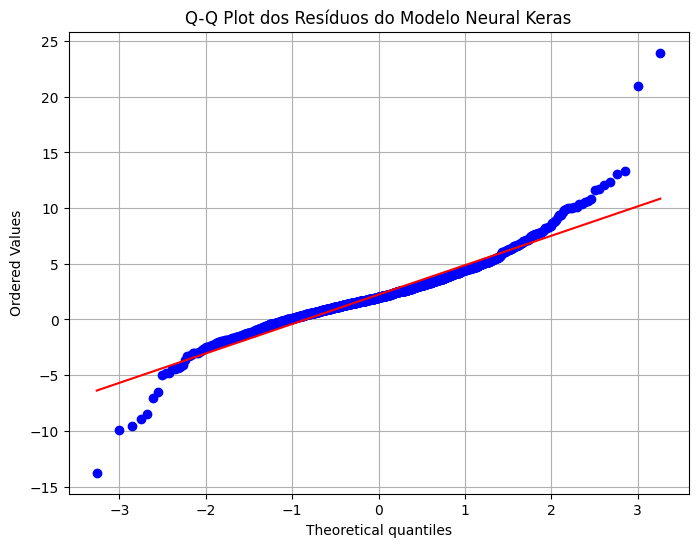

In [288]:
# Cálculo dos resíduos para o modelo Keras
# É importante usar os valores originais (não escalonados) para os resíduos
residuos_keras = Y_teste.values.ravel() - Y_pred_teste_keras_original.ravel()

print("\n--- Análise dos Resíduos do Modelo Keras ---")
print(f"Média dos Resíduos Keras: {np.mean(residuos_keras):.4f}")
print(f"Desvio Padrão dos Resíduos Keras: {np.std(residuos_keras):.4f}")
print(f"Min Resíduos Keras: {np.min(residuos_keras):.4f}")
print(f"Max Resíduos Keras: {np.max(residuos_keras):.4f}")

# Gráfico de Resíduos (Resíduos vs. Valores Previstos) para o modelo Keras
plt.figure(figsize=(10, 6))
sns.scatterplot(x=Y_pred_teste_keras_original.ravel(), y=residuos_keras, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Valores Previstos (Escala Original)')
plt.ylabel('Resíduos (Real - Previsto)')
plt.title('Gráfico de Resíduos para o Modelo Neural Keras')
plt.grid(True)
plt.savefig('keras_residual_plot.png') # Salvar o gráfico, se desejar
plt.show()

# Q-Q plot dos resíduos para verificar a normalidade
plt.figure(figsize=(8, 6))
stats.probplot(residuos_keras, dist="norm", plot=plt)
plt.title('Q-Q Plot dos Resíduos do Modelo Neural Keras')
plt.grid(True)
plt.savefig('keras_qq_plot.png') # Salvar o gráfico, se desejar
plt.show()


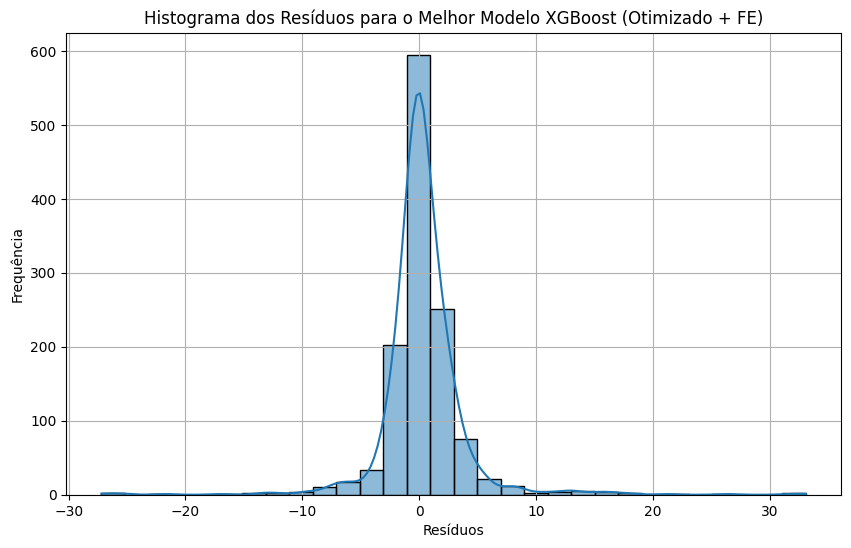

In [275]:
# Histograma dos Resíduos
plt.figure(figsize=(10, 6))
sns.histplot(residuos, kde=True, bins=30)
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.title('Histograma dos Resíduos para o Melhor Modelo XGBoost (Otimizado + FE)')
plt.grid(True)
plt.savefig('xgb_fe_residuals_histogram.png')
plt.show()

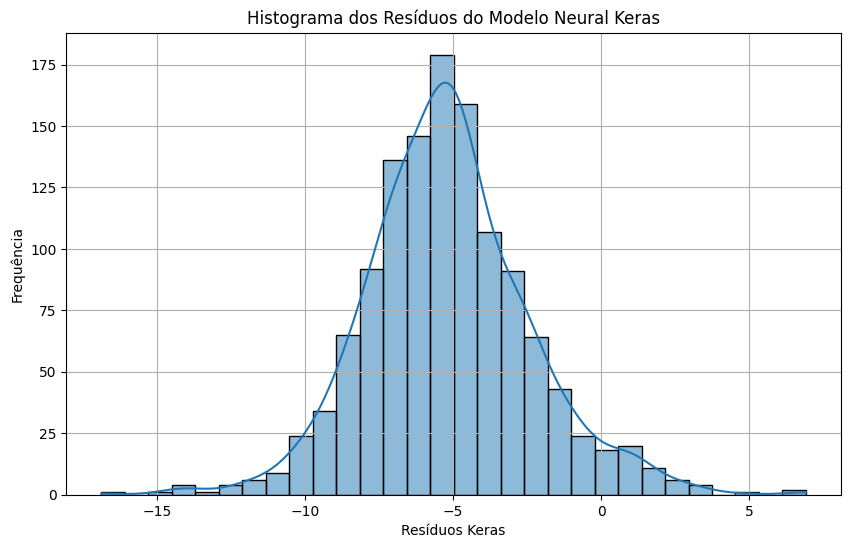

In [276]:
# prompt: mostre o histograma dos resíduos do keras

import matplotlib.pyplot as plt
# Histograma dos Resíduos Keras
plt.figure(figsize=(10, 6))
sns.histplot(residuos_keras, kde=True, bins=30)
plt.xlabel('Resíduos Keras')
plt.ylabel('Frequência')
plt.title('Histograma dos Resíduos do Modelo Neural Keras')
plt.grid(True)
plt.savefig('keras_residuals_histogram.png')
plt.show()

In [277]:
# Identificar os pontos com os maiores erros
df_erros = pd.DataFrame({
    'Real': Y_teste_np,
    'Previsto': Y_pred_teste_best_xgb_fe_original_np,
    'Resíduo': residuos,
    'Resíduo Absoluto': np.abs(residuos)
})
erros_maiores = df_erros.sort_values(by='Resíduo Absoluto', ascending=False).head(10)
print("\n--- 10 Maiores Erros (Resíduos Absolutos) ---")
print(erros_maiores)


--- 10 Maiores Erros (Resíduos Absolutos) ---
        Real     Previsto    Resíduo  Resíduo Absoluto
248   1600.0  1566.883057  33.116943         33.116943
1121  1690.0  1658.282593  31.717407         31.717407
1243  1520.0  1547.197510 -27.197510         27.197510
711   1480.0  1453.796875  26.203125         26.203125
202   1100.0  1126.192139 -26.192139         26.192139
944   1100.0  1125.280396 -25.280396         25.280396
351   1110.0  1131.753662 -21.753662         21.753662
616   1470.0  1448.775146  21.224854         21.224854
201   1140.0  1121.822388  18.177612         18.177612
344   1140.0  1122.507690  17.492310         17.492310


In [289]:
comparison_df = pd.DataFrame(model_results).T
print(comparison_df.to_string(float_format="%.10f"))

                          R2 (Treino - Escalonado)  MSE (Treino - Escalonado)  R2 (Teste - Escalonado)  MSE (Teste - Escalonado)  R2 (Treino - Original)  MSE (Treino - Original)  R2 (Teste - Original)  MSE (Teste - Original)
Linear Regression                     0.8300983975               0.0070020910             0.8356501912              0.0068504434            0.8300983975         19762.7015379993           0.8356501912        19334.6913373913
RandomForestRegressor                 0.9996828613               0.0000130701             0.9980125361              0.0000828416            0.9996828613            36.8891023460           0.9980125361          233.8122619471
XGBoost (Base)                        0.9998698860               0.0000053623             0.9981344264              0.0000777610            0.9998698831            15.1346712112           0.9981344342          219.4726409912
Keras Neural Network                  0.9999175508               0.0000033979             0.99989353